<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/CV-2025/blob/main/Week_11/MovingMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pytorch-lightning clearml

In [2]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchmetrics

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_info
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import numpy as np

from clearml import Task
import re

In [3]:
#Enter your code here to implement Step 2 of the logging instruction as it is shown below
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
%env CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
env: CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I


In [4]:
config = {
    # Data Config
    "img_size": 64,
    "num_frames": 20,
    "batch_size": 32,

    #Architecture
    "architecture": '3DCNN',

    # 3D CNN
    "conv3d_channels": [1, 32, 64],  # Input channels for each Conv3D layer
    "kernel_size": 3,
    "pool_size": 2,
    "linear_hidden": 128,

    # Training
    "max_epochs": 10,
    "learning_rate": 1e-3,
    "early_stop_patience": 10,

    # System
    "accelerator": "auto",
    "log_dir": "./logs",
    "checkpoint_dir": "./checkpoints"
}

In [5]:
class MovingMNIST(Dataset):
    def __init__(self, train=True, img_size=64, num_frames=20):
        self.mnist = MNIST(root='./data', train=train, download=True, transform=ToTensor())
        self.img_size = img_size
        self.num_frames = num_frames

    def __len__(self):
        return len(self.mnist) // 2

    def __getitem__(self, idx):
        digit1, label1 = self.mnist[2 * idx]
        digit2, label2 = self.mnist[2 * idx + 1]

        frames = []
        # Initialize positions within valid bounds (0 <= pos <= img_size - 28)
        pos1 = np.random.randint(0, self.img_size - 28 + 1, size=2)  # [x, y]
        pos2 = np.random.randint(0, self.img_size - 28 + 1, size=2)
        vel1 = np.random.randint(-3, 4, size=2)
        vel2 = np.random.randint(-3, 4, size=2)

        for _ in range(self.num_frames):
            frame = torch.zeros((1, self.img_size, self.img_size))

            # Update positions with bounce logic
            def update_pos(pos, vel):
                new_pos = pos + vel
                # Reflect velocity if out of bounds
                for i in range(2):  # x and y axes
                    if new_pos[i] < 0:
                        vel[i] *= -1
                        new_pos[i] = 0
                    elif new_pos[i] > (self.img_size - 28):
                        vel[i] *= -1
                        new_pos[i] = 2*(self.img_size - 28) - new_pos[i]
                return new_pos

            pos1 = update_pos(pos1, vel1)
            pos2 = update_pos(pos2, vel2)

            # Add digits to frame (positions now guaranteed valid)
            x1, y1 = int(pos1[0]), int(pos1[1])
            frame[:, y1:y1+28, x1:x1+28] += digit1.squeeze()
            x2, y2 = int(pos2[0]), int(pos2[1])
            frame[:, y2:y2+28, x2:x2+28] += digit2.squeeze()

            frames.append(frame.clamp(0, 1))

        video = torch.stack(frames)
        target = label1 + label2
        return video, target

In [6]:
class VideoClassifier(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.save_hyperparameters()

        # Build Conv3D layers dynamically
        conv_layers = []
        in_channels = config["conv3d_channels"][0]
        for out_channels in config["conv3d_channels"][1:]:
            conv_layers.extend([
                nn.Conv3d(in_channels, out_channels, kernel_size=config["kernel_size"]),
                nn.ReLU(),
                nn.MaxPool3d(config["pool_size"])
            ])
            in_channels = out_channels

        self.conv3d = nn.Sequential(*conv_layers)

        # Calculate classifier input size
        with torch.no_grad():
            dummy_input = torch.rand(1, 1, config["num_frames"], config["img_size"], config["img_size"])
            dummy_output = self.conv3d(dummy_input)
            self.classifier_input_size = dummy_output.numel() // dummy_output.size(0)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.classifier_input_size, config["linear_hidden"]),
            nn.ReLU(),
            nn.Linear(config["linear_hidden"], 19)  # 19 possible sums (0-18)
        )

        # Metrics
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=19)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=19)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=19)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)  # (B,T,C,H,W) -> (B,C,T,H,W)
        return self.classifier(self.conv3d(x))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.config["learning_rate"])

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        self.test_acc(y_hat, y)
        self.log("test_acc", self.test_acc, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)

In [7]:
def visualize_batch(batch, n_frames=4):
    """Plot first 4 frames of first 4 videos in batch"""
    videos, targets = batch
    fig, axes = plt.subplots(4, n_frames, figsize=(15, 8))

    for i in range(4):  # First 4 samples
        for j in range(n_frames):  # First n_frames
            frame_idx = j * (videos.shape[1] // n_frames)
            axes[i,j].imshow(videos[i, frame_idx, 0], cmap='gray')
            axes[i,j].set_title(f"Target: {targets[i].item()}")
            axes[i,j].axis('off')
    plt.tight_layout()
    plt.show()

def visualize_predictions(batch, model, n_samples=3):
    videos, true_sums = batch
    model.eval()

    with torch.no_grad():
        preds = model(videos).argmax(dim=1)

    fig, axes = plt.subplots(n_samples, 3, figsize=(12, n_samples*3))
    for i in range(n_samples):
        # Show first frame
        axes[i,0].imshow(videos[i,0,0], cmap='gray')
        axes[i,0].set_title(f"First Frame")
        axes[i,0].axis('off')

        # Show middle frame
        mid_frame = len(videos[i])//2
        axes[i,1].imshow(videos[i,mid_frame,0], cmap='gray')
        axes[i,1].set_title(f"Frame {mid_frame}")
        axes[i,1].axis('off')

        # Show prediction
        axes[i,2].text(0.1, 0.5,
                      f"True Sum: {true_sums[i].item()}\nPredicted: {preds[i].item()}",
                      fontsize=12)
        axes[i,2].axis('off')

    plt.tight_layout()
    plt.show()


In [8]:
# Initialize ClearML
task = Task.init(project_name="MovingMNIST",
                 task_name="digits_sum_classification",
                 auto_connect_frameworks={
                     'pytorch': True, 'tensorboard': False, 'matplotlib': True, 'tensorflow': True,
                     'xgboost': True, 'scikit': True, 'fastai': True, 'lightgbm': True,
                     'hydra': True, 'detect_repository': True, 'tfdefines': True, 'joblib': True,
                     'megengine': True, 'catboost': True
                },
)

# Initialize everything with config
model = VideoClassifier(config)

task.connect(model.hparams)

# Define datasets
train_dataset = MovingMNIST(train=True)
val_dataset = MovingMNIST(train=False)
test_dataset = MovingMNIST(train=False)  # Using same as val for demo (replace with real test set, it is a small cheat)

train_loader = DataLoader(
    MovingMNIST(train=True, img_size=config["img_size"], num_frames=config["num_frames"]),
    batch_size=config["batch_size"],
    shuffle=True
)

val_loader = DataLoader(
    MovingMNIST(train=False, img_size=config["img_size"], num_frames=config["num_frames"]),
    batch_size=config["batch_size"]
)

test_loader = DataLoader(
    MovingMNIST(train=False, img_size=config["img_size"], num_frames=config["num_frames"]),
    batch_size=config["batch_size"]
)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    dirpath=config["checkpoint_dir"],
    filename=config['architecture'] + "best_model-{epoch}-{val_loss:.2f}",
    save_weights_only=True,
    auto_insert_metric_name=False,
    save_on_train_epoch_end=False  # Ensures epoch is recorded correctly
)
early_stop_callback = EarlyStopping(monitor="val_loss", patience=5)


# Trainer
trainer = pl.Trainer(
    max_epochs=config["max_epochs"],
    accelerator=config["accelerator"],
    logger=CSVLogger(save_dir=config["log_dir"]),
    callbacks=[
        checkpoint_callback,
        EarlyStopping(monitor="val_loss", patience=config["early_stop_patience"])
    ]
)

trainer.fit(model, train_loader, val_loader)

ClearML Task: created new task id=0a599a41d4a84e60a93fcd01fd2c42c4
2025-03-31 11:42:29,764 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/a8d0f10864894a109852e10fb6ce4fbf/experiments/0a599a41d4a84e60a93fcd01fd2c42c4/output/log


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | conv3d     | Sequential         | 56.3 K | train
1 | classifier | Sequential         | 4.8 M  | train
2 | train_acc  | MulticlassAccuracy | 0      | train
3 | val_acc    | MulticlassAccuracy | 0      | train
4 | test_acc   | MulticlassAccuracy | 0      | train
----------------------------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.503    Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [9]:
best_path = checkpoint_callback.best_model_path
best_score = checkpoint_callback.best_model_score
rank_zero_info(f"Best model: {best_path}")
rank_zero_info(f"Best val_loss: {best_score:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:Best model: /content/checkpoints/3DCNNbest_model-9-2.44.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Best val_loss: 2.4429


In [10]:
if best_path:
    rank_zero_info(f"Best model saved at: {best_path}")
    rank_zero_info(f"Best validation loss: {best_score:.4f}")

    # Robust epoch extraction
    match = re.search(r'epoch=(\d+)', best_path)
    epoch = int(match.group(1)) if match else "unknown"
    print(f"Best model epoch: {epoch}")

    # Load and test
    model = VideoClassifier.load_from_checkpoint(best_path)
    trainer.test(model, test_loader)
else:
    print("No checkpoint saved - validation may not have run properly")

INFO:pytorch_lightning.utilities.rank_zero:Best model saved at: /content/checkpoints/3DCNNbest_model-9-2.44.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Best validation loss: 2.4429


Best model epoch: unknown


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.19359999895095825    │
└───────────────────────────┴───────────────────────────┘

In [11]:
# Visualize a test batch
test_batch = next(iter(test_loader))
# visualize_batch(test_batch)

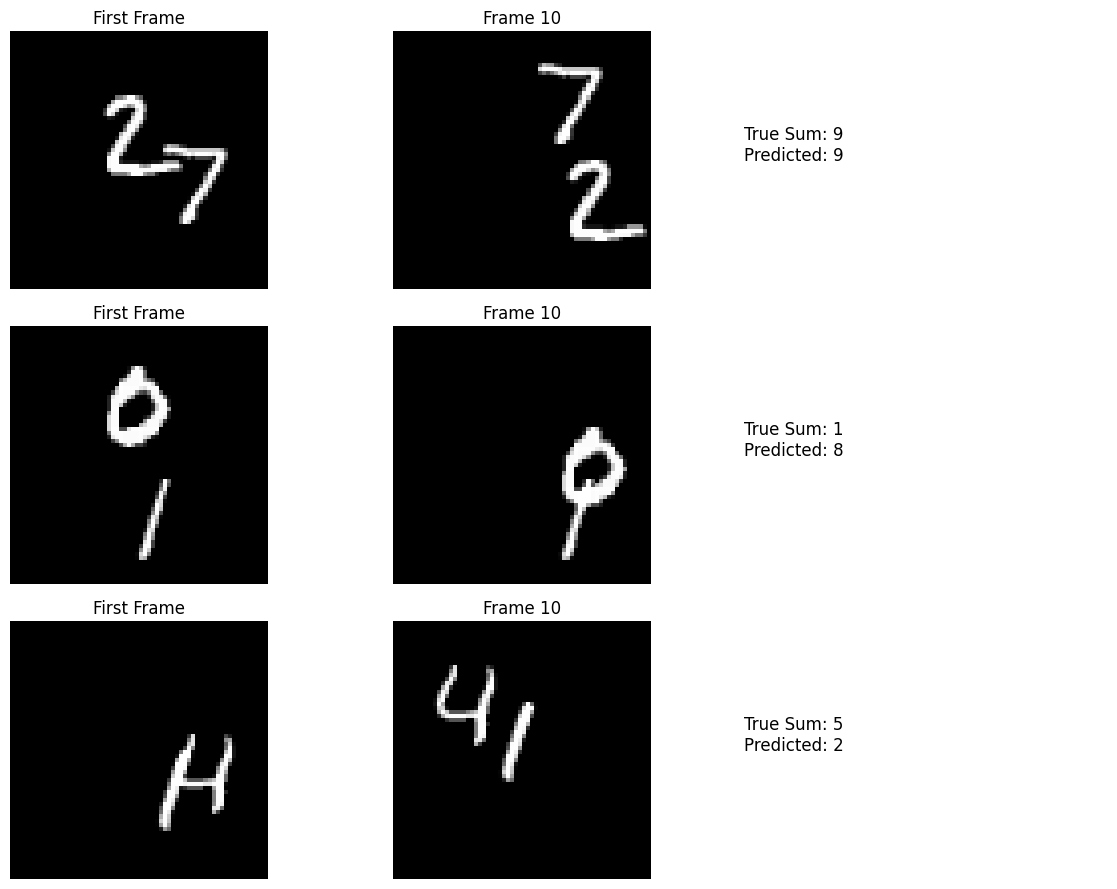

In [12]:
# Visualize with test batch
visualize_predictions(test_batch, model)

In [13]:
task.close()